In [1]:
from IPython.display import display, Markdown
import pandas as pd
import geopandas as gpd
import numpy as np

from geopy.distance import geodesic
from shapely.geometry import Polygon, Point

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn import metrics

# Description of Data
This dataset represents deliveries made to customers from the Distribution Center. Each record corresponds to a shipment and contains the following information:

- Customer Code (cod_customer): Unique identifier for each customer.
- Date (date): The date when the delivery was made.
- Longitude (lon): Geographic longitude of the customer location.
- Latitude (lat): Geographic latitude of the customer location.
- Demand / Shipment / Package Volume (demand): Quantity delivered to the customer on that date, representing the shipment volume or demand.

# Data
## Load Data

In [2]:
raw_data = (
    pd.read_csv("../../data/raw/base_customers_all_years_z7.csv")
      .assign(
          date=lambda x: pd.to_datetime(x['date']),
          year=lambda x: x['date'].dt.year,
          month=lambda x: x['date'].dt.month
      )
) # transform dtype, and extract year and month for each date

## Exploration Data

Descriptive metrics of demand by Year, in raw data

,count,mean,std,min,20%,30%,40%,50%,60%,70%,80%,90%,max
year,,,,,,,,,,,,,
2020,709538.0,3.813977,11.616414,-4.00000,1.0,1.0,1.0,2.0,2.0,2.0,3.0,6.0,500.00000
2021,897861.0,3.715884,12.101470,-55.00000,1.0,1.0,1.0,1.0,2.0,2.0,3.0,5.0,500.00000
2022,1161436.0,4.005496,65.979601,-34720.66667,1.0,1.0,1.0,2.0,2.0,3.0,4.0,7.0,34722.66667


Removed 66430 negative-rows (2.40% of data)

Removed 184042 outliers-rows (6.81% of total)

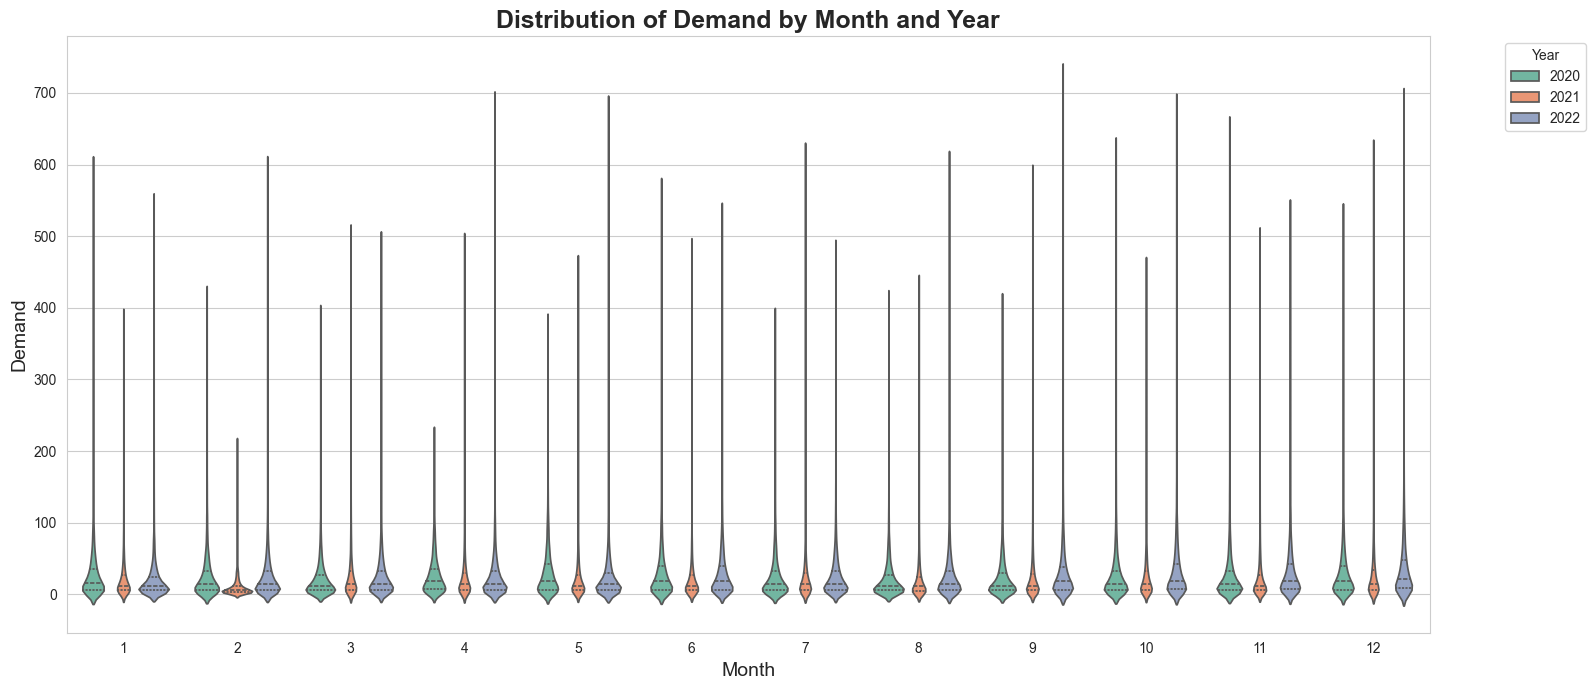

Descriptive metrics of demand by Year, in grouped data

,count,mean,std,min,20%,30%,40%,50%,60%,70%,80%,90%,max
year,,,,,,,,,,,,,
2020,56307.0,26.796886,36.268965,1.0,4.0,6.0,10.0,15.0,21.0,30.0,40.0,63.0,654.0
2021,76243.0,23.553756,34.374904,1.0,4.0,6.0,9.0,12.0,18.0,24.0,33.0,54.0,621.0
2022,88107.0,28.312335,39.472998,1.0,6.0,9.0,12.0,15.0,21.0,30.0,42.0,66.0,726.0


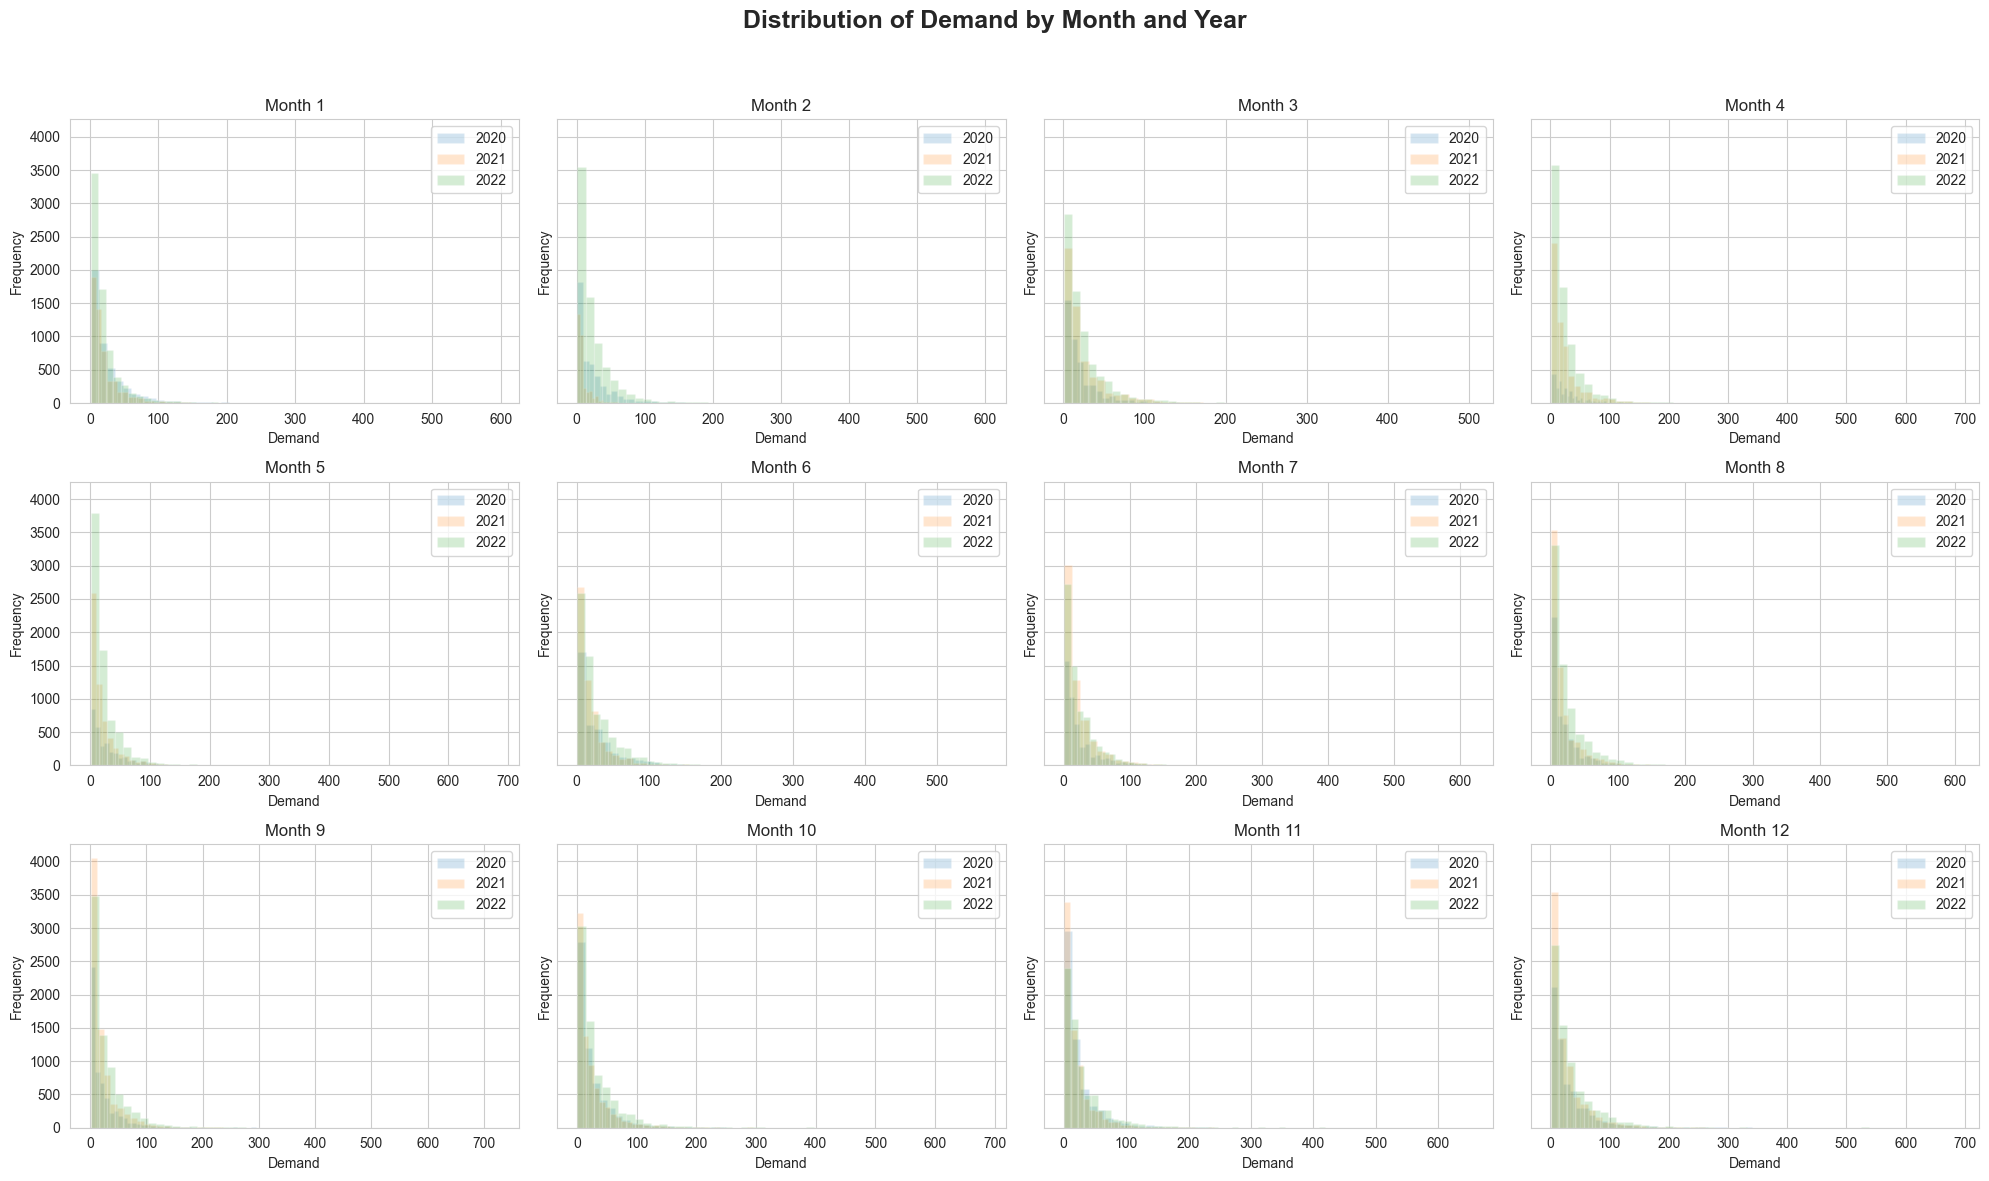

In [3]:
# percentiles of demand distribution per year
display(Markdown("Descriptive metrics of demand by Year, in raw data"))
display(
    raw_data.groupby('year')['demand']
       .describe(percentiles=[i/10 for i in range(2,10)])
)

# --- Remove negative demand ---
data = raw_data[raw_data['demand'] > 0].reset_index(drop=True)
display(Markdown(f"Removed {(raw_data['demand'] <= 0).sum()} negative-rows ({(raw_data['demand'] <= 0).mean()*100:.2f}% of data)"))
# --- Filter extreme values ---
p_low, p_high = data['demand'].quantile([0.05, 0.95])
n_before = len(data)
data = data[data['demand'].between(p_low, p_high)].reset_index(drop=True)
display(Markdown(f"Removed {n_before - len(data)} outliers-rows ({(n_before - len(data))/n_before*100:.2f}% of total)"))

# --- Aggregate demand per year, month, customer ---
data_grouped = (
    data
    .groupby(["year", "month", "cod_customer", "lat", "lon"], as_index=False)
    .agg(
        demand=("demand", "sum"),
        n_dates=("date", "nunique")
    )
)

plt.figure(figsize=(16,7))
sns.set_style("whitegrid")

sns.violinplot(
    x='month',
    y='demand',
    hue='year',
    data=data_grouped,
    palette="Set2",
    inner="quartile", 
    split=False
)

plt.title('Distribution of Demand by Month and Year', fontsize=18, weight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Demand', fontsize=14)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# percentiles of demand of month distribution per year
display(Markdown("Descriptive metrics of demand by Year, in grouped data"))
display(
    data_grouped.groupby('year')['demand']
       .describe(percentiles=[i/10 for i in range(2,10)])
)


months = sorted(data_grouped['month'].unique())
years = sorted(data_grouped['year'].unique())
fig, axes = plt.subplots(3, 4, figsize=(20, 12), sharey=True)
axes = axes.flatten()
for i, month in enumerate(months):
    ax = axes[i]
    for year in years:
        data_subset = data_grouped[(data_grouped['month'] == month) & (data_grouped['year'] == year)]
        ax.hist(
            data_subset['demand'],
            bins=50,
            alpha=0.2,
            label=str(year)
        )
    ax.set_title(f'Month {month}')
    ax.set_xlabel('Demand')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.suptitle('Distribution of Demand by Month and Year', fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Pixelation process


<u>Step 1 – Identify Frequent Customers and normalize demand</u>

We will consider the daily average demand per customer within each month. Therefore, The customer’s monthly demand will be divided by the number of days on which an order was placed, and the demand will be rounded to the nearest integer number.

It is important to note that there're customers who purchase only once (infrequent). Therefore, for this study, we will consider frequent customers—i.e., all customers in 2022 who made at least one purchase per month.

In [4]:
months_per_customer = (
    data_grouped[data_grouped['year'] == 2022]
    .groupby('cod_customer')['month']
    .nunique()
)
frequent_customers_2022 = months_per_customer[months_per_customer == 12].index

data_prev_years = data_grouped[(data_grouped['cod_customer'].isin(frequent_customers_2022))]
pct_by_year = (
    data_prev_years
    .groupby('year')['demand']
    .sum()
    / data_grouped.groupby('year')['demand'].sum()
    * 100
)
pct_df = pd.DataFrame({
    'Year': pct_by_year.index,
    'Percentage of demand from 2022 frequent customers (%)': pct_by_year.values.round(2)
})

display(pct_df)

data_customer = data_grouped[data_grouped.cod_customer.isin(frequent_customers_2022)].reset_index(drop=True)
data_customer['daily_demand'] = np.ceil(data_customer['demand'] / data_customer['n_dates']).astype('int64')

## output: data_customer

,Year,Percentage of demand from 2022 frequent customers (%)
0,2020,66.65
1,2021,70.30
2,2022,76.15


In [5]:
display(Markdown('Resumen of data considering into Process - After Step 1'))
display(data_customer.groupby(['year','month']).agg(
    n_customer = ('cod_customer','nunique'),
    total_daily_demand = ('daily_demand','sum'),
    avg_daily_demand = ('daily_demand','mean')
))

Resumen of data considering into Process - After Step 1

n_customer  total_daily_demand  avg_daily_demand
year month                                                  
2020 1            1871               21422         11.449492
     2            1900               20834         10.965263
     3            1903               19879         10.446138
     4            1439               15480         10.757470
     5            1589               17280         10.874764
     6            1868               21175         11.335653
     7            2155               22579         10.477494
     8            2237               21931          9.803755
     9            2482               24388          9.825947
     10           2624               26385         10.055259
     11           2677               27147         10.140829
     12           2726               30416         11.157740
2021 1            2687               24962          9.289914
     2            1855               13394          7.220485
     3            2874               27387          9.529228
     4            2894               27524          9.510712
     5            2935               26796          9.129813
     6            3000               25832          8.610667
     7            3069               27984          9.118280
     8            3495               32398          9.269814
     9            3656               33258          9.096827
     10           3764               35612          9.461211
     11           3791               34039          8.978897
     12           3867               38437          9.939747
2022 1            4009               35137          8.764530
     2            4009               41980         10.471439
     3            4009               41047         10.238713
     4            4009               39825          9.933899
     5            4009               39004          9.729110
     6            4009               45768         11.416313
     7            4009               41119         10.256672
     8            4009               38778          9.672736
     9            4009               42561         10.616363
     10           4009               45704         11.400349
     11           4009               46053         11.487403
     12           4009               48651         12.135445

<u>Step 2 – Determine Number of Layers<u>

To determine the number of layers, we must consider the total demand of each customer, thereby preventing a customer from being present in two layers in different periods.

We will use Silhouette Score to determine the Number of Layers. This metric determines the quality of each layer.

Disclaimer:

We eliminate clients with high and volatile demand:

cod_customer = [156596, 604632, 604633, 604634, 604635, 604636, 604637, 604638, 604639, 604657, 604658, 604659, 604660, 604661, 612998, 616804, 619058, 621658, 621778, 621913, 622281, 673167, 800417, 825577]

In [6]:
BLACK_LIST = [156596, 604632, 604633, 604634, 604635, 604636, 604637, 604638, 604639, 604657, 604658, 604659, 604660, 604661, 612998, 616804, 619058, 621658, 621778, 621913, 622281, 673167, 800417, 825577]

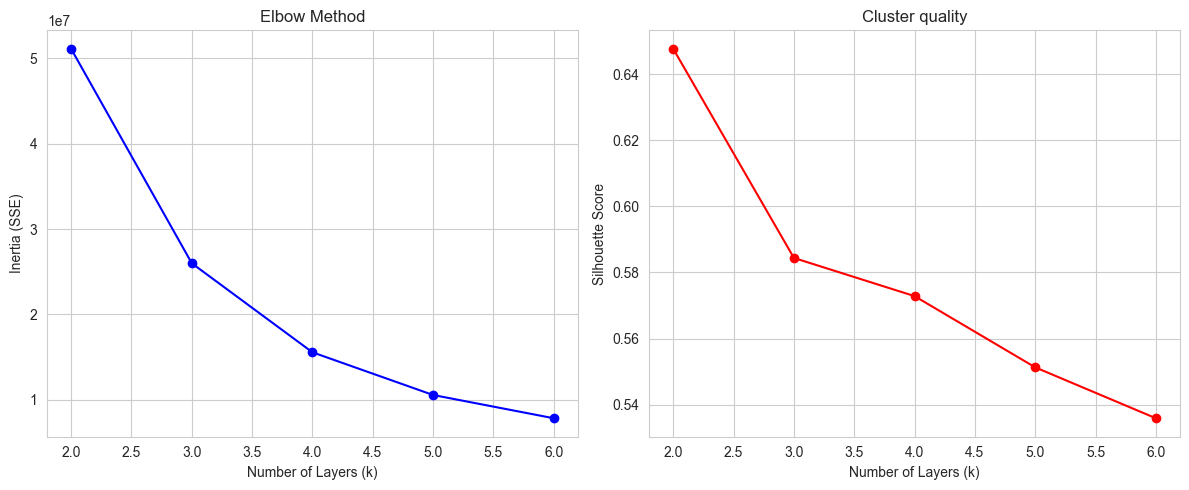

In [7]:
customer_demand = (
    data_customer[~data_customer['cod_customer'].isin(BLACK_LIST)]
    .groupby("cod_customer", as_index=False)
    .agg(total_demand=("daily_demand", "sum"))
)

X = customer_demand[["total_demand"]].values

inertia, silhouette = [], []
K = range(2, 7)  # try from 2 to 6 layers

for k in K:
    km = KMeans(
        n_clusters=k, 
        random_state=42, 
        n_init=3
    ).fit(X)
    inertia.append(km.inertia_)
    silhouette.append(metrics.silhouette_score(X, km.labels_))

# --- Plot metrics ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertia, "bo-")
plt.xlabel("Number of Layers (k)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method")

plt.subplot(1,2,2)
plt.plot(K, silhouette, "ro-")
plt.xlabel("Number of Layers (k)")
plt.ylabel("Silhouette Score")
plt.title("Cluster quality")

plt.tight_layout()
plt.show()

We decided to create 2 layers because the Silhouette Score is the highest, indicating that this division better represents the clusters.
- segment A
- segment B

<u>Step 3 – Assign Customers to Layers<u>

In [8]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=2)
customer_demand["cluster"] = kmeans.fit_predict(X)

# sort clusters by avg demand
cluster_order = (
    customer_demand.groupby("cluster")["total_demand"]
    .mean()
    .sort_values()
    .index
)

# assign cluster → layer
mapping = {cluster_order[0]: "A", cluster_order[1]: "B"}
customer_demand["layer"] = customer_demand["cluster"].map(mapping)

data_with_layers = data_customer.merge(
    customer_demand[["cod_customer", "layer"]],
    on="cod_customer",
    how="left"
)

data_with_layers.head(2)

,year,month,cod_customer,lat,lon,demand,n_dates,daily_demand,layer
0,2020,1,32841,-16.538044,-68.076248,33.0,2,17,B
1,2020,1,32843,-16.539955,-68.050613,12.0,4,3,A


# Plot and Describe Each Layer

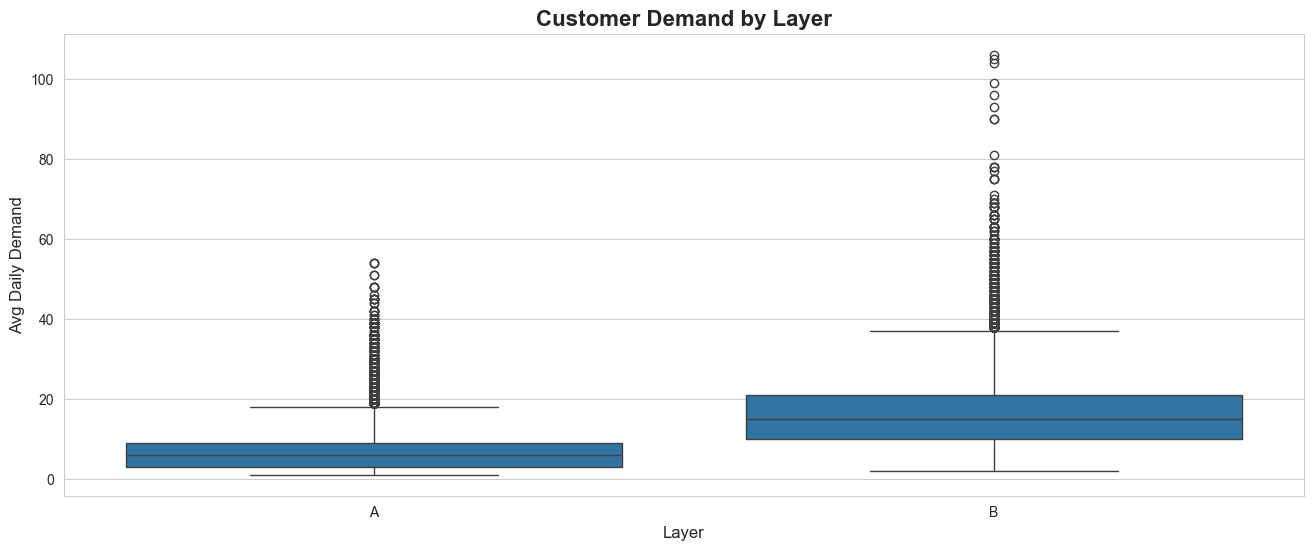

In [9]:
sns.set_style("whitegrid")

layers = data_with_layers["layer"].unique()

plt.figure(figsize=(16,6))
sns.boxplot(
    x="layer",
    y="daily_demand",
    data=data_with_layers,
    order=["A", "B"],
)

plt.title("Customer Demand by Layer", fontsize=16, weight="bold")
plt.xlabel("Layer", fontsize=12)
plt.ylabel("Avg Daily Demand", fontsize=12)
plt.show()

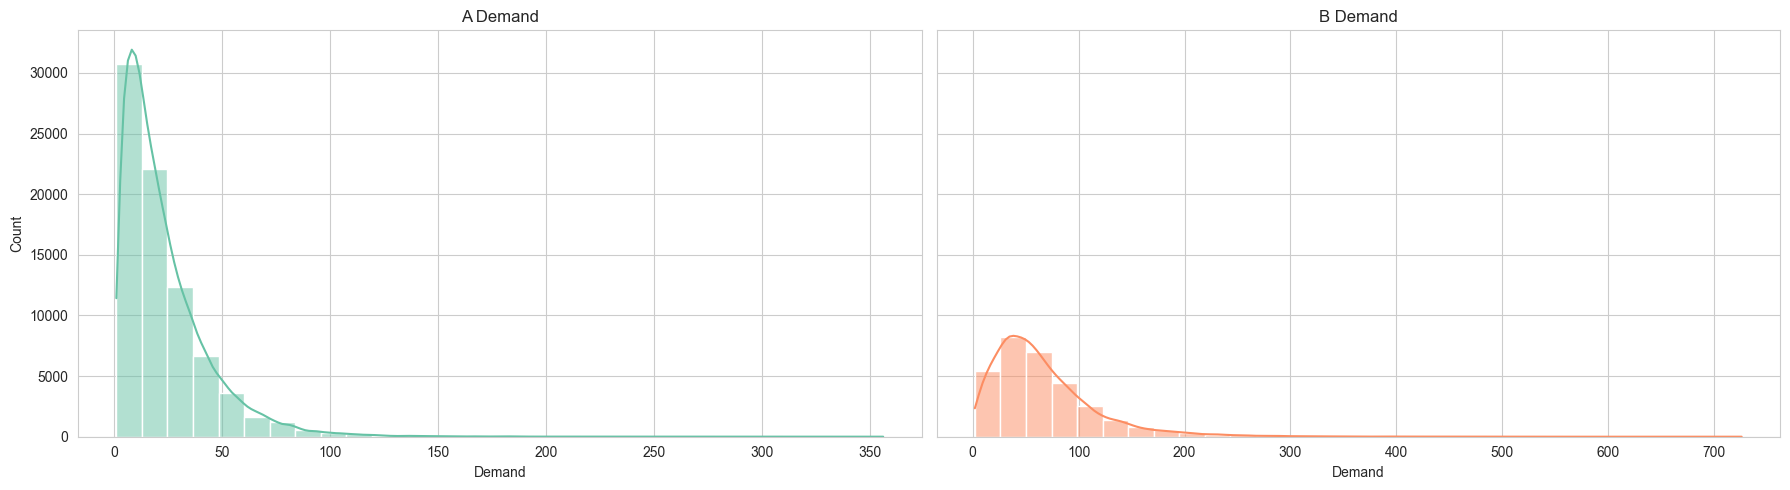

Descriptive of daily demand by Layer

,count,mean,std,min,25%,50%,75%,max
layer,,,,,,,,
A,79653.0,6.858963,4.568351,1.0,3.0,6.0,9.0,54.0
B,30964.0,16.630280,9.056397,2.0,10.0,15.0,21.0,106.0


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(18,5), sharey=True)
sns.set_style("whitegrid")

for i, layer in enumerate(["A", "B"]):
    sns.histplot(
        data_with_layers[data_with_layers["layer"] == layer],
        x="demand",
        bins=30,
        kde=True,
        ax=axes[i],
        color=sns.color_palette("Set2")[i]
    )
    axes[i].set_title(f"{layer} Demand")
    axes[i].set_xlabel("Demand")
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

display(Markdown('Descriptive of daily demand by Layer'))
display(data_with_layers.groupby('layer')['daily_demand'].describe())

# Creation Pixel


In [11]:
class Grid:
    """Create a km x km grid and assign customers to pixels."""

    def __init__(self, df: pd.DataFrame, km_distance: float = 1.0):
        self.df = df.copy()
        self.km = km_distance
        self.grid_gdf = None
        self.output = None

    def _delta_lat_lon(self, lat: float):
        """Approx km distance in degrees."""
        delta_lat = geodesic(kilometers=self.km).destination((lat, 0), 0)[0] - lat
        delta_lon = geodesic(kilometers=self.km).destination((lat, 0), 90)[1]
        return delta_lat, delta_lon

    def create_grid(self):
        min_lat, max_lat = self.df["lat"].min(), self.df["lat"].max()
        min_lon, max_lon = self.df["lon"].min(), self.df["lon"].max()
        delta_lat, delta_lon = self._delta_lat_lon(min_lat)

        polygons = []
        for i in range(int(np.ceil((max_lat - min_lat) / delta_lat))):
            for j in range(int(np.ceil((max_lon - min_lon) / delta_lon))):
                top_left_lat = min_lat + i * delta_lat
                top_left_lon = min_lon + j * delta_lon
                polygons.append(
                    Polygon([
                        (top_left_lon, top_left_lat),
                        (top_left_lon + delta_lon, top_left_lat),
                        (top_left_lon + delta_lon, top_left_lat - delta_lat),
                        (top_left_lon, top_left_lat - delta_lat)
                    ])
                )
        self.grid_gdf = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")
        self.grid_gdf["pixel"] = np.arange(len(self.grid_gdf))

    def assign_pixels(self):
        gdf_points = gpd.GeoDataFrame(
            self.df,
            geometry=gpd.points_from_xy(self.df["lon"], self.df["lat"]),
            crs="EPSG:4326"
        )
        assigned = gpd.sjoin(gdf_points, self.grid_gdf, how="left", predicate="within")
        self.output = assigned.drop(columns=["geometry", "index_right"])

    def run(self):
        self.create_grid()
        self.assign_pixels()
        return self.output


In [12]:
grid_creator = Grid(data_with_layers, km_distance=1)
data_with_pixels = grid_creator.run()

data_with_pixels.head()

,year,month,cod_customer,lat,lon,demand,n_dates,daily_demand,layer,pixel
0,2020,1,32841,-16.538044,-68.076248,33.0,2,17,B,122.0
1,2020,1,32843,-16.539955,-68.050613,12.0,4,3,A,124.0
2,2020,1,32847,-16.539769,-68.054479,12.0,2,6,A,124.0
3,2020,1,32856,-16.501939,-68.104086,9.0,1,9,A,183.0
4,2020,1,32867,-16.505890,-68.100774,36.0,3,12,B,183.0


In [13]:
data_with_pixels[(data_with_pixels.pixel == 26) & (data_with_pixels.layer=='A')]

,year,month,cod_customer,lat,lon,demand,n_dates,daily_demand,layer,pixel
2305,2020,2,678091,-16.60031,-68.070523,3.0,1,3,A,26.0
9191,2020,6,678091,-16.60031,-68.070523,6.0,2,3,A,26.0
11321,2020,7,678091,-16.60031,-68.070523,6.0,2,3,A,26.0
13565,2020,8,678091,-16.60031,-68.070523,6.0,2,3,A,26.0
15994,2020,9,678091,-16.60031,-68.070523,9.0,3,3,A,26.0
23988,2020,12,678091,-16.60031,-68.070523,9.0,3,3,A,26.0
26710,2021,1,678091,-16.60031,-68.070523,3.0,1,3,A,26.0
29009,2021,2,678091,-16.60031,-68.070523,3.0,1,3,A,26.0
31373,2021,3,678091,-16.60031,-68.070523,12.0,4,3,A,26.0
34263,2021,4,678091,-16.60031,-68.070523,6.0,2,3,A,26.0


In [14]:
data_with_pixels.groupby(['layer',"pixel"], as_index=False).agg(
                  daily_demand_mean=("daily_demand", "mean"),
                  daily_demand_std=("daily_demand", "std"),
                  n_customers=("cod_customer", "nunique"),
              )

,layer,pixel,daily_demand_mean,daily_demand_std,n_customers
0,A,26.0,5.177778,2.433562,2
1,A,71.0,6.613757,3.631133,7
2,A,72.0,6.361493,3.708228,20
3,A,73.0,7.147679,4.950531,9
4,A,87.0,9.679245,5.257864,3
...,...,...,...,...,...
211,B,258.0,13.850000,4.452480,2
212,B,261.0,11.500000,6.371813,1
213,B,274.0,21.068966,7.544776,1
214,B,280.0,19.309091,10.047798,2


In [15]:
class PixelHeatmap:
    """
    Plot heatmaps on multiple pixel grids, supporting different grids per layer.
    """

    def __init__(self, grid_main: gpd.GeoDataFrame, data: pd.DataFrame, grid_secondary: gpd.GeoDataFrame = None):
        self.grid_main = grid_main.copy()
        self.data = data.copy()

        self.layer_grids = {"A": self.grid_main}

        if grid_secondary is not None:
            self.grid_secondary = grid_secondary.copy()
            self.layer_grids["B"] = self.grid_secondary

    def aggregate_metrics(self, layer: str = None) -> pd.DataFrame:
        df = self.data.copy()
        if layer:
            df = df[df['layer'] == layer]

        agg_df = (
            df.groupby("pixel", as_index=False)
              .agg(
                  drop_mean=("daily_demand", "mean"),
                  drop_std=("daily_demand", "std"),
                  n_customers=("cod_customer", "nunique"),
              )
##              .assign(daily_drop_mean=lambda x: x.daily_demant_total / x.n_customers)
        )
        return agg_df

    def plot_metric_layers(
        self, 
        metric: str, 
        layers=("A", "B"), 
        cmap="YlOrRd", 
        figsize=(18,9), 
        annotate=True, 
        annotate_pixel_id=False,
        save=True
    ):
        n_layers = len(layers)
        fig, axes = plt.subplots(1, n_layers, figsize=figsize)

        if n_layers == 1:
            axes = [axes]

        fig.suptitle(f"{metric.replace('_',' ').title()} per Pixel by Layer", fontsize=16, weight='bold')

        for ax, layer in zip(axes, layers):
            agg_df = self.aggregate_metrics(layer=layer)
            grid = self.layer_grids.get(layer, self.grid_main)
            gdf_plot = grid.merge(agg_df, left_index=True, right_on="pixel", how="left")
            gdf_plot[metric] = gdf_plot[metric].replace(0, pd.NA)

            # Plot polygons
            gdf_plot.boundary.plot(ax=ax, linewidth=0.5, edgecolor="lightgrey")
            gdf_plot.plot(
                ax=ax,
                column=metric,
                cmap=cmap,
                linewidth=0.5,
                edgecolor="lightgrey",
                legend=True
            )

            # Annotate metric values
            if annotate:
                for _, row in gdf_plot.dropna(subset=[metric]).iterrows():
                    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
                    ax.annotate(
                        text=f"{row[metric]:.1f}",
                        xy=(x, y),
                        ha='center',
                        va='center',
                        fontsize=8,
                        color='black'
                    )

            # Annotate pixel IDs
            if annotate_pixel_id:
                for _, row in gdf_plot.dropna(subset=[metric]).iterrows():
                    if row[metric] > 0:
                        x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
                        ax.annotate(
                            text=f"ID:{row['pixel']}",
                            xy=(x, y),
                            xytext=(0, 10),
                            textcoords="offset points",
                            ha='center',
                            va='bottom',
                            fontsize=7,
                            color='blue'
                        )

            ax.set_title(f"Layer {layer} - {metric.replace('_',' ').title()}", fontsize=14)
            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")
            ax.grid(False)

        plt.tight_layout(rect=[0, 0, 1, 0.95])

        if save:
            fig.savefig(f"../../data/pixels/pixel_heatmap_{metric}.svg", format="svg")

        plt.show()

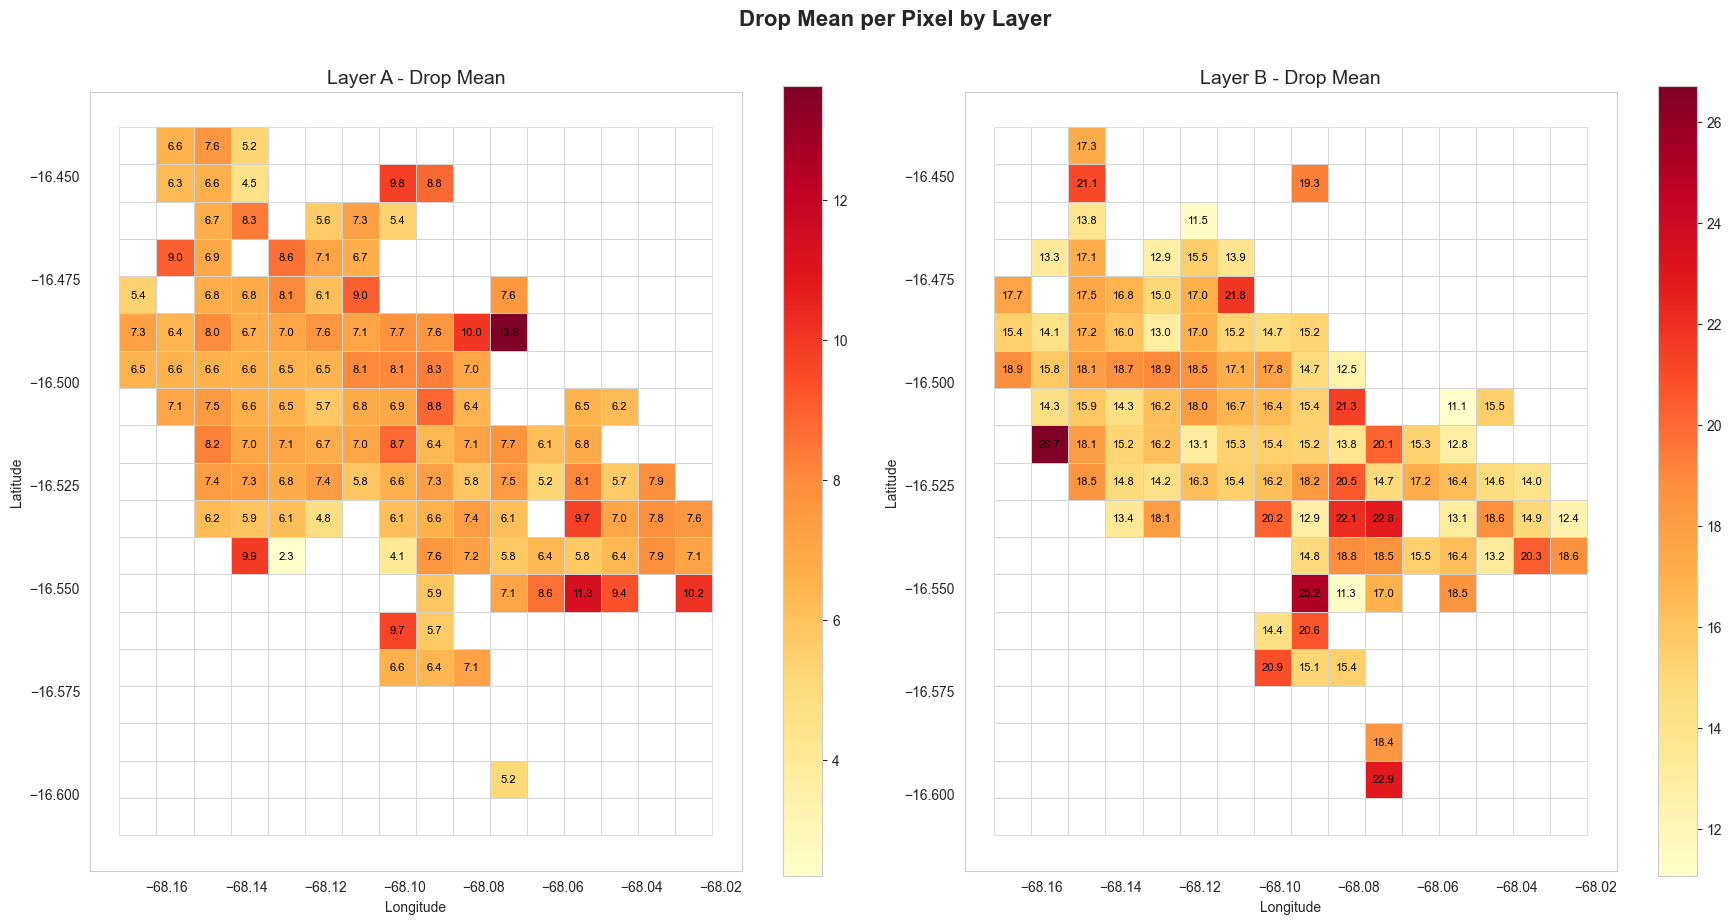

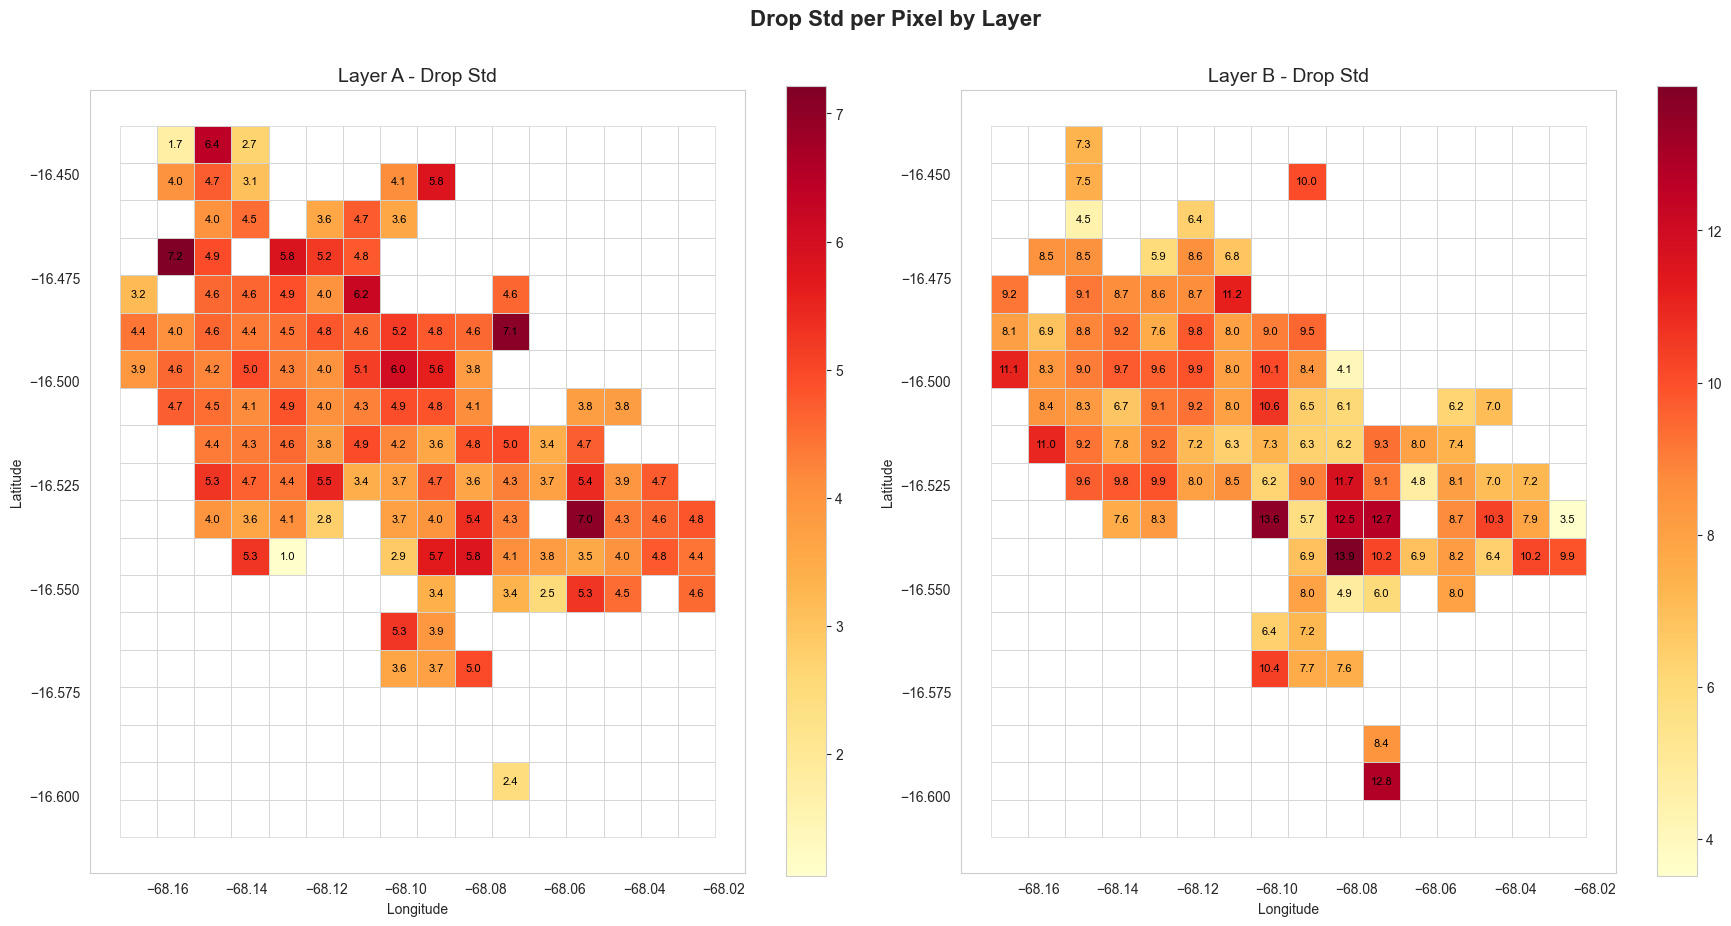

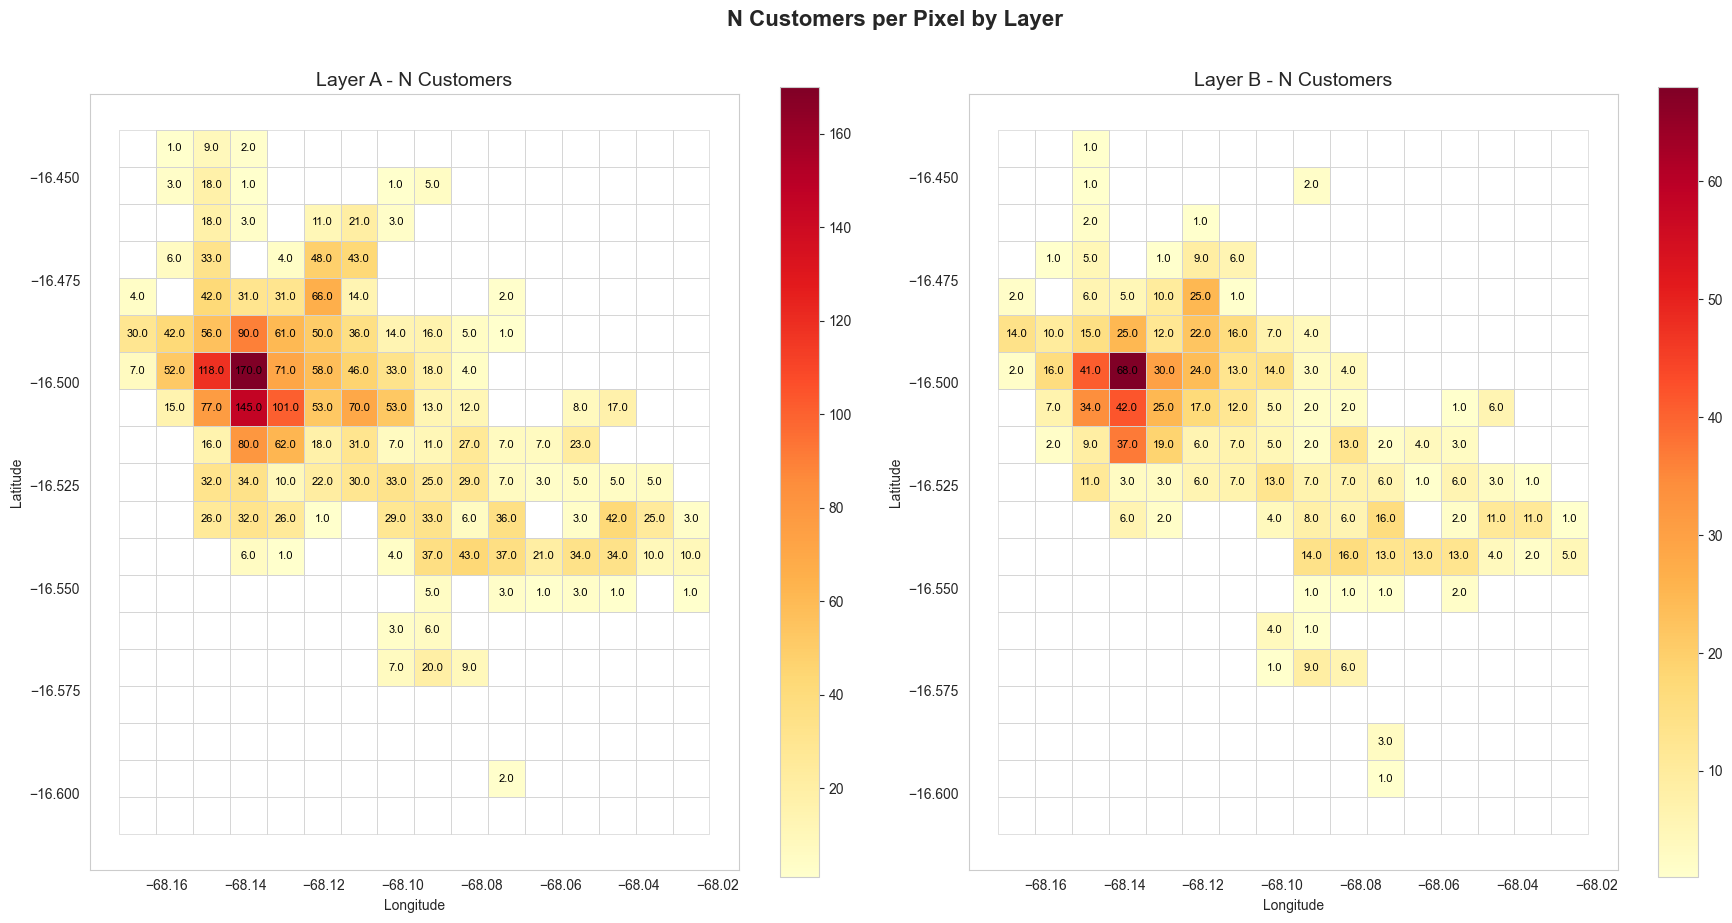

In [16]:
heatmap = PixelHeatmap(grid_main=grid_creator.grid_gdf, data=data_with_pixels)
heatmap.plot_metric_layers(metric="drop_mean")
heatmap.plot_metric_layers(metric="drop_std")
heatmap.plot_metric_layers(metric="n_customers")

# Aggreation process


In [38]:
import geopandas as gpd
import pandas as pd
from shapely.ops import unary_union

class LayeredPixelMerger:
    """
    Merge pixels into larger convex rectangles per layer.
    Keeps the original grid intact and creates a separate grid for each layer.
    """

    def __init__(self, grid_gdf: gpd.GeoDataFrame, data: pd.DataFrame):
        """
        grid_gdf: GeoDataFrame with pixel geometries (indexed by pixel ID)
        data: DataFrame with columns ["pixel", "layer", ...]
        """
        self.original_grid = grid_gdf.copy()   # never modified

        # Si no existe una columna de área, asumimos 1 km² por pixel original
        if "area_km2" not in self.original_grid.columns:
            self.original_grid["area_km2"] = 1.0

        self.layer_grids = {}                  # dict[layer] = GeoDataFrame for that layer
        self.data = data.copy()
        self.last_merges = {}                  # dict[layer] = last merge info

    def _get_layer_grid(self, layer: str) -> gpd.GeoDataFrame:
        """
        Return the GeoDataFrame for the layer. 
        If it doesn't exist yet, start from original grid.
        """
        if layer not in self.layer_grids:
            self.layer_grids[layer] = self.original_grid.copy()
        return self.layer_grids[layer]

    def merge_pixels(self, pixel_ids: list[int], layer: str) -> gpd.GeoDataFrame:
        """
        Merge a list of pixels into a single rectangle for a specific layer.
        Keeps the smallest pixel ID as new identifier.
        Updates both the layer grid and the data for that layer.

        IMPORTANTE: actualiza también el área (area_km2) del nuevo píxel
        como la suma de las áreas de los píxeles originales.
        """
        # Get or create the layer grid
        layer_grid = self._get_layer_grid(layer)

        # Subset pixels in the layer grid
        subset = layer_grid.loc[pixel_ids]
        if subset.empty:
            raise ValueError(f"Pixel IDs {pixel_ids} not found in grid for layer {layer}.")

        new_id = min(pixel_ids)

        # Área nueva = suma de las áreas originales
        new_area = subset["area_km2"].sum()

        # Merge geometries
        merged_geom = unary_union(subset.geometry)
        merged_geom = gpd.GeoSeries([merged_geom]).envelope[0]  # convex rectangle

        # Tomamos una fila base (para copiar otras columnas si existen)
        base_row = subset.iloc[0].copy()

        # Actualizamos geometría y área en esa base
        base_row["geometry"] = merged_geom
        base_row["area_km2"] = new_area

        # Dropeamos los píxeles originales
        layer_grid = layer_grid.drop(index=pixel_ids)

        # Insertamos el nuevo píxel con new_id
        layer_grid.loc[new_id] = base_row

        self.layer_grids[layer] = layer_grid

        # Update data only for this layer
        mask_data = (self.data["pixel"].isin(pixel_ids)) & (self.data["layer"] == layer)
        self.data.loc[mask_data, "pixel"] = new_id

        # Save last merge info
        self.last_merges[layer] = {
            "merged_pixels": pixel_ids,
            "new_id": new_id,
            "new_area_km2": float(new_area),
        }

        return layer_grid

    def get_layer_grid(self, layer: str) -> gpd.GeoDataFrame:
        """Return the current grid for the given layer."""
        return self._get_layer_grid(layer)

    def get_data(self) -> pd.DataFrame:
        """Return the dataset with updated pixel IDs."""
        return self.data

    def get_last_merge(self, layer: str) -> dict:
        """Return information about the last merge for a layer."""
        return self.last_merges.get(layer, {})

    def reset_layer(self, layer: str):
        """Reset the layer grid and data to original state for this layer."""
        self.layer_grids[layer] = self.original_grid.copy()
        # Reset pixel IDs in data for this layer
        mask = self.data["layer"] == layer
        self.data.loc[mask, "pixel"] = self.data.loc[mask, "pixel"]  # could reset to original mapping if stored
        if layer in self.last_merges:
            del self.last_merges[layer]

    def reset(self):
        """Reset all layers and data to original state."""
        self.layer_grids = {}
        self.data = self.data.copy()
        self.last_merges = {}

    def delete_pixel(self, pixel_id: int, layer: str):
        """
        Delete a pixel from a specific layer and from the data.
        Does not affect the original grid or other layers.
        """
        layer_grid = self._get_layer_grid(layer)

        if pixel_id not in layer_grid.index:
            raise ValueError(f"Pixel ID {pixel_id} not found in grid for layer {layer}.")

        # layer_grid = layer_grid.drop(index=pixel_id)
        # self.layer_grids[layer] = layer_grid

        mask = (self.data["pixel"] == pixel_id) & (self.data["layer"] == layer)
        self.data = self.data.loc[~mask].copy()
        self.last_merges[layer] = {"deleted_pixel": pixel_id}

    def get_pixel_centroids(self) -> pd.DataFrame:
        """
        Devuelve un DataFrame con columnas:
        - layer
        - pixel
        - lon
        - lat
        - area_km2   --> área resultante (después de merges)
    
        lon/lat corresponden al centroide del polígono del pixel
        en el grid actual de cada layer.
    
        IMPORTANTE: Se asume que las geometrías están en lon/lat (EPSG:4326).
        """
        rows = []
    
        # Para cada layer presente en los datos
        for layer in self.data["layer"].unique():
            grid = self._get_layer_grid(layer)
    
            # Pixels presentes en el data frame para este layer
            pixels_layer = self.data.loc[self.data["layer"] == layer, "pixel"].unique()
    
            # Filtrar a los que realmente existen en el grid (después de merges)
            pixels = [p for p in pixels_layer if p in grid.index]
    
            if not pixels:
                continue
    
            subset = grid.loc[pixels]
    
            # Centroide de cada pixel
            centroids = subset.geometry.centroid
    
            for pixel_id, point in centroids.items():
                area_km2 = subset.loc[pixel_id, "area_km2"] if "area_km2" in subset.columns else None
    
                rows.append({
                    "layer": layer,
                    "pixel": pixel_id,
                    "lon": point.x,
                    "lat": point.y,
                    "area_surface": area_km2,
                })
    
        return pd.DataFrame(rows)


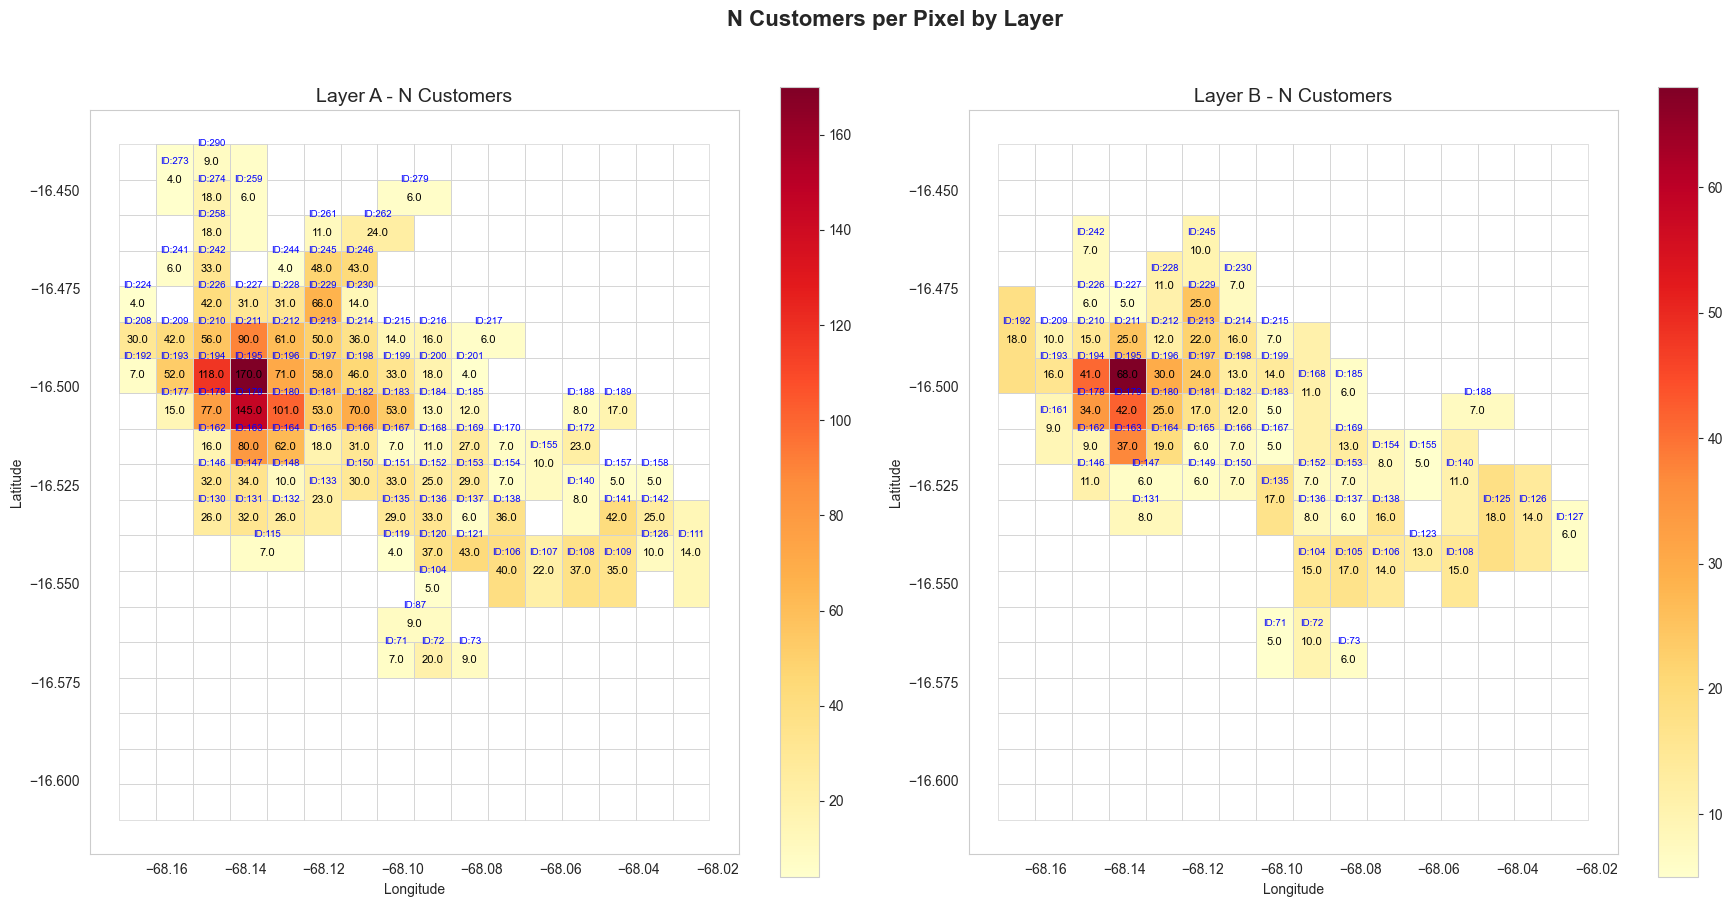

In [39]:
heatmap.plot_metric_layers(
    metric="n_customers", 
    annotate=True,
    annotate_pixel_id=True,
    save=False
)

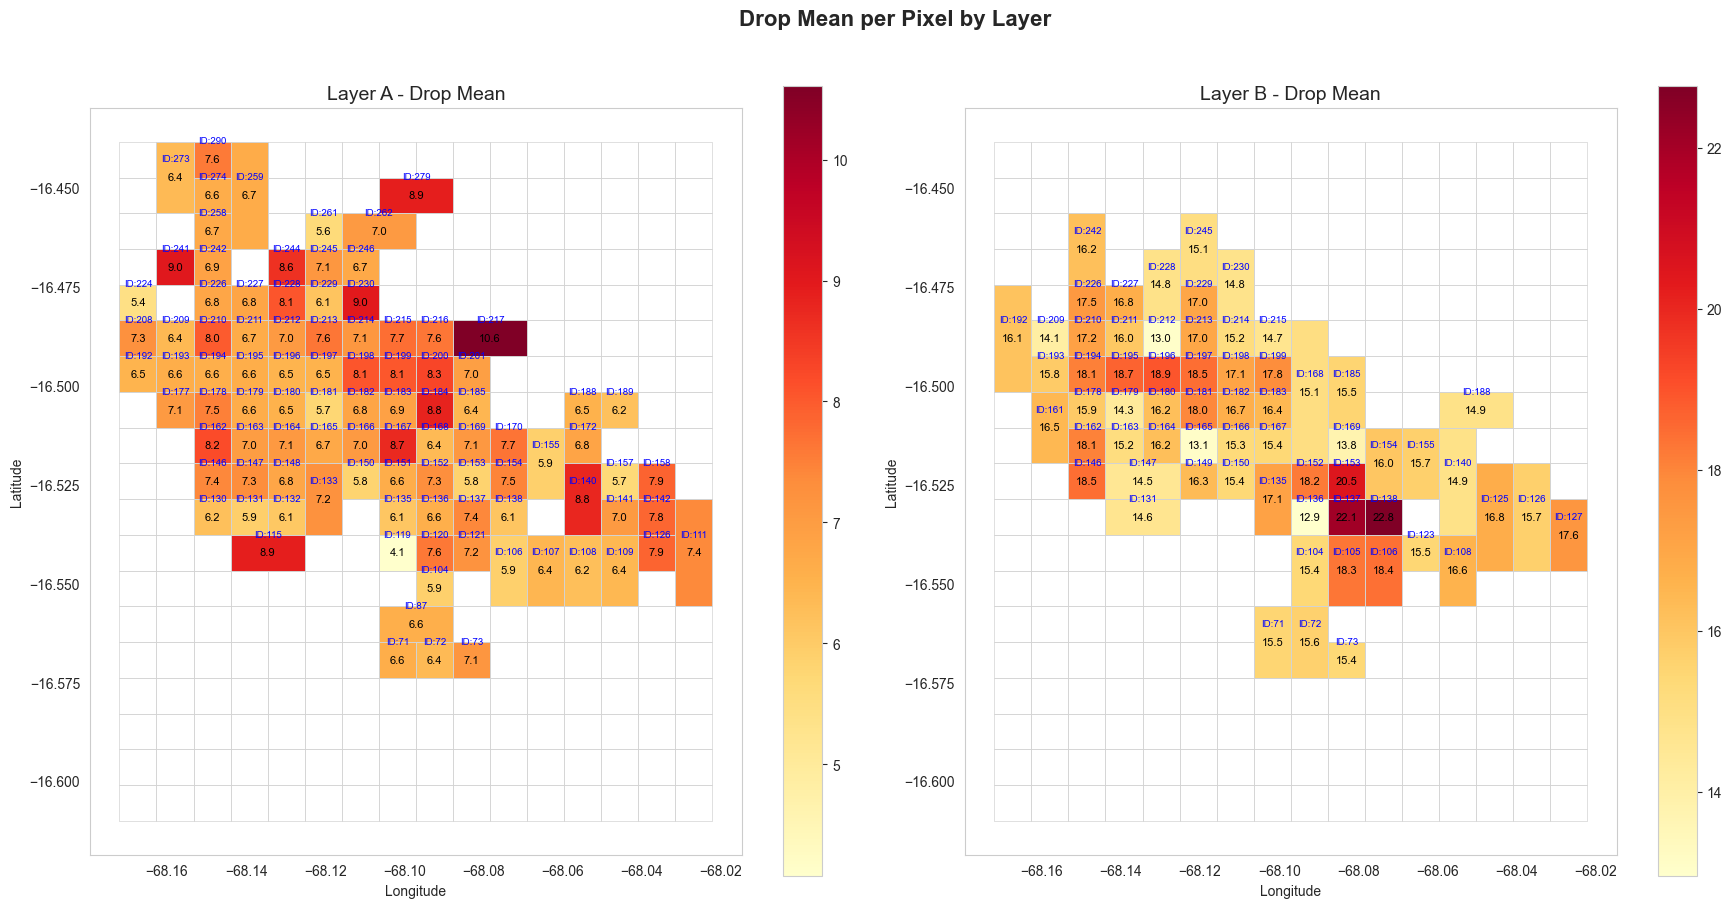

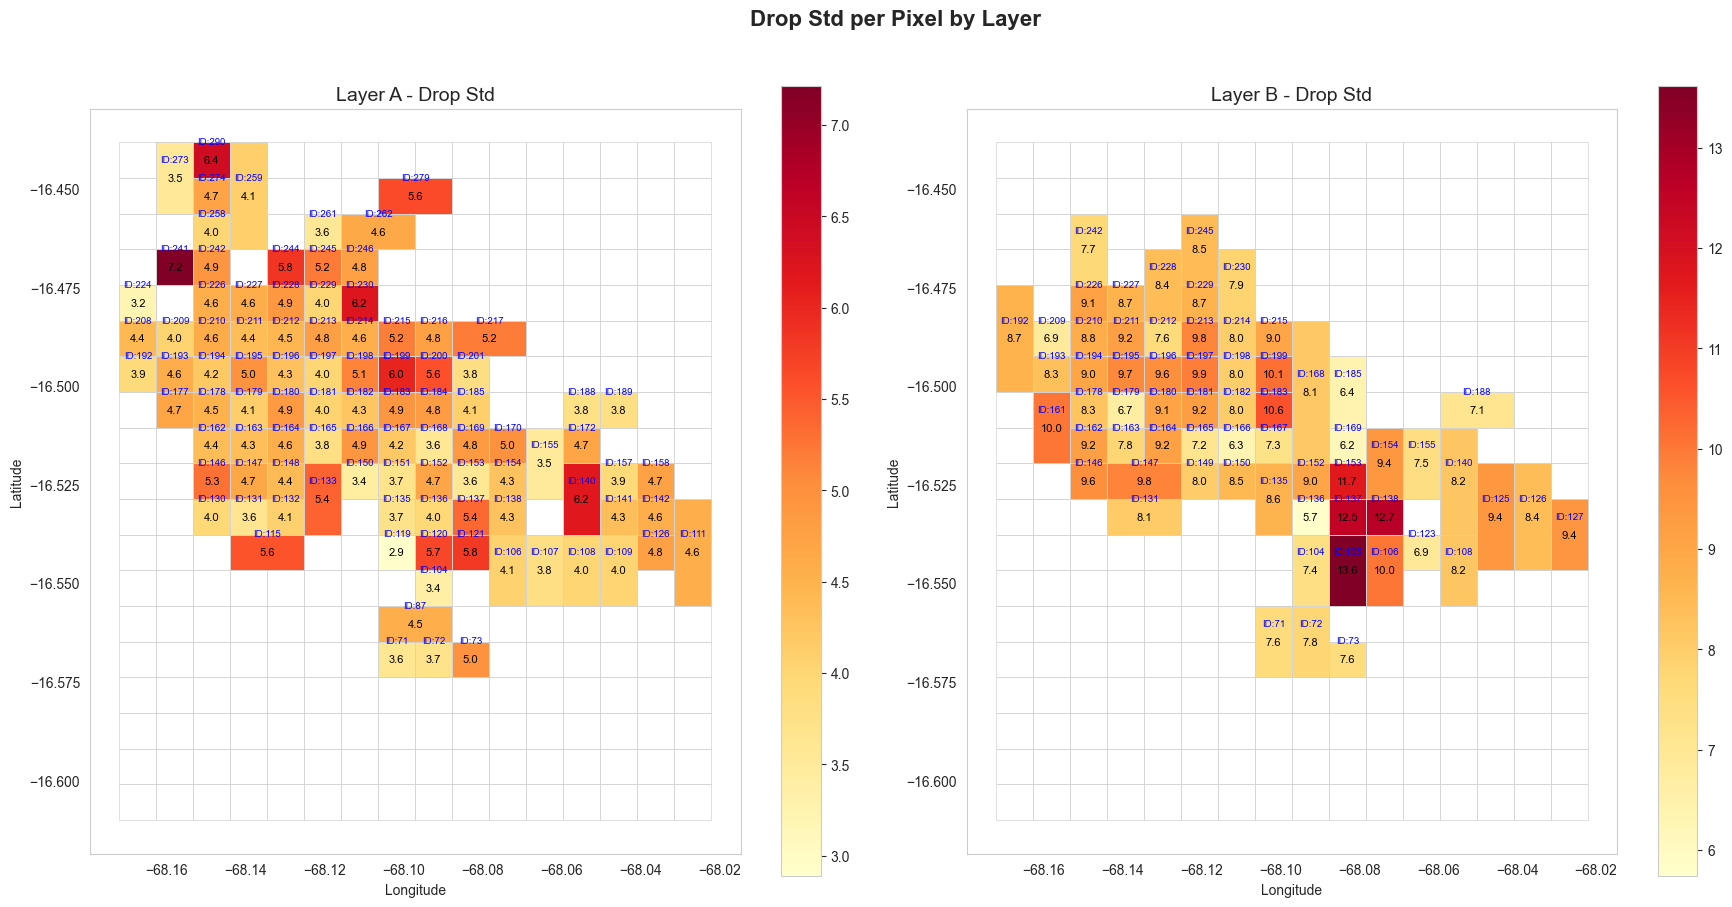

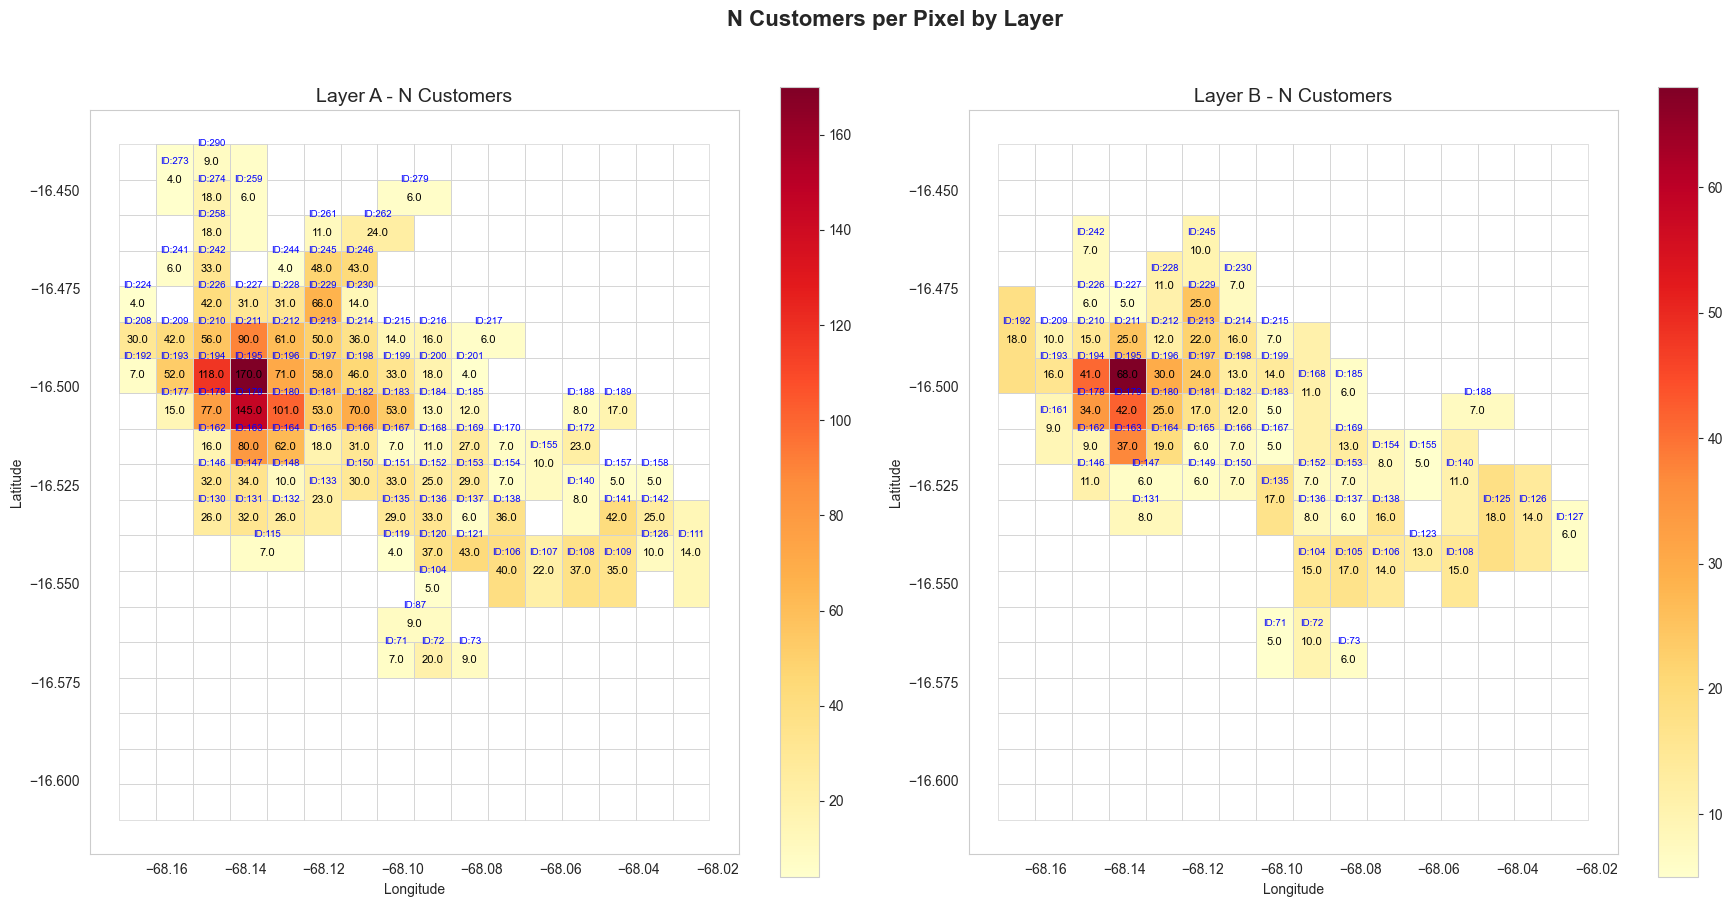

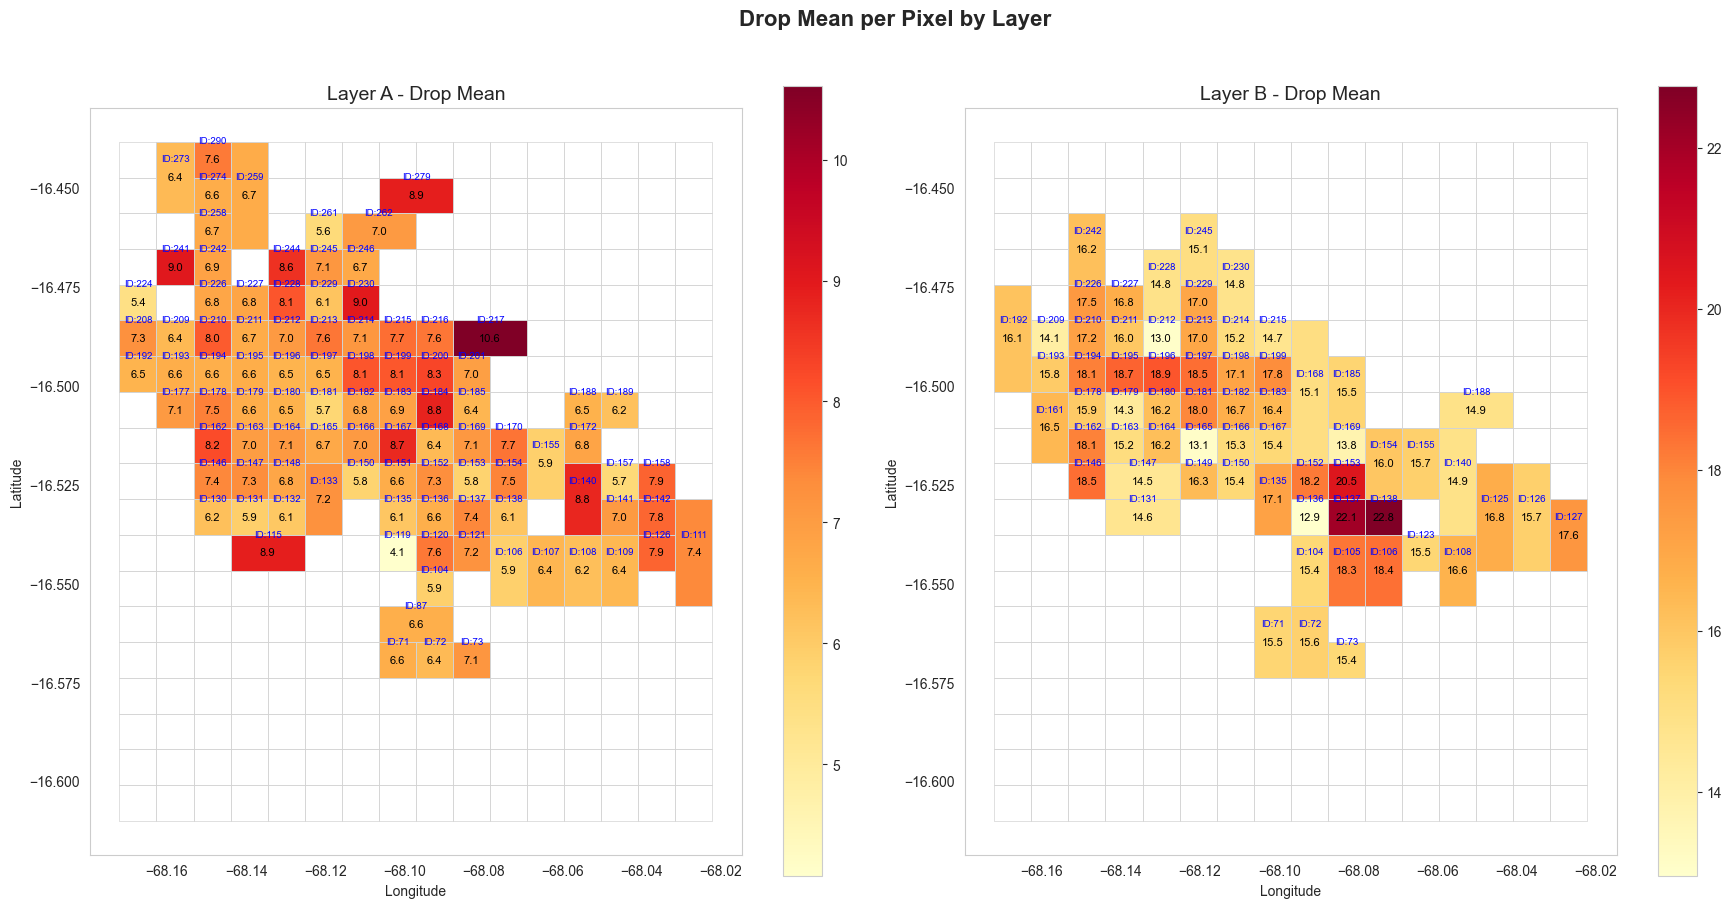

In [40]:
merger = LayeredPixelMerger(grid_gdf=grid_creator.grid_gdf, data=data_with_pixels)

# These pixels would be removed from the grid because they are not significant
merger.delete_pixel(layer='A', pixel_id=26)
merger.delete_pixel(layer='A', pixel_id=234)
merger.delete_pixel(layer='B', pixel_id=26)
merger.delete_pixel(layer='B', pixel_id=42)
merger.delete_pixel(layer='B', pixel_id=274)
merger.delete_pixel(layer='B', pixel_id=280)
merger.delete_pixel(layer='B', pixel_id=290)
merger.delete_pixel(layer='B', pixel_id=241)

# These pixels will be combined to have pixels with a minimum of customers/stops.
merger.merge_pixels([289, 273], layer="A")
merger.merge_pixels([291, 275, 259], layer="A")
merger.merge_pixels([115, 116], layer="A")
merger.merge_pixels([133, 149], layer="A")
merger.merge_pixels([279, 280], layer="A")
merger.merge_pixels([263, 262], layer="A")
merger.merge_pixels([217, 218], layer="A")
merger.merge_pixels([106, 122], layer="A")
merger.merge_pixels([107, 123], layer="A")
merger.merge_pixels([108, 124], layer="A")
merger.merge_pixels([109, 125], layer="A")
merger.merge_pixels([87, 88], layer="A")
merger.merge_pixels([127, 111, 143], layer="A")
merger.merge_pixels([156, 140], layer="A")
merger.merge_pixels([171, 155], layer="A")

merger.merge_pixels([258, 242], layer="B")
merger.merge_pixels([224, 208, 192], layer="B")
merger.merge_pixels([177, 161], layer="B")
merger.merge_pixels([147, 148], layer="B")
merger.merge_pixels([131, 132], layer="B")
merger.merge_pixels([244, 228], layer="B")
merger.merge_pixels([261, 245], layer="B")
merger.merge_pixels([246, 230], layer="B")
merger.merge_pixels([216, 200, 184, 168], layer="B")
merger.merge_pixels([201, 185], layer="B")
merger.merge_pixels([170, 154], layer="B")
merger.merge_pixels([171, 155], layer="B")
merger.merge_pixels([120, 104], layer="B")
merger.merge_pixels([121, 105], layer="B")
merger.merge_pixels([122, 106], layer="B")
merger.merge_pixels([72, 88], layer="B")
merger.merge_pixels([71, 87], layer="B")
merger.merge_pixels([124, 108], layer="B")
merger.merge_pixels([151, 135], layer="B")
merger.merge_pixels([188, 189], layer="B")
merger.merge_pixels([172, 156, 140], layer="B")
merger.merge_pixels([157, 141, 125], layer="B")
merger.merge_pixels([158, 142, 126], layer="B")
merger.merge_pixels([143, 127], layer="B")


grid_A, grid_B = merger.get_layer_grid('A'), merger.get_layer_grid('B')
data_updated = merger.get_data()

heatmap = PixelHeatmap(grid_main=grid_A, grid_secondary=grid_B, data=data_updated)
heatmap.plot_metric_layers(metric="drop_mean", annotate_pixel_id=True, save=False)
heatmap.plot_metric_layers(metric="drop_std", annotate_pixel_id=True, save=False)
heatmap.plot_metric_layers(metric="n_customers", annotate_pixel_id=True, save=False)
heatmap.plot_metric_layers(metric="drop_mean", annotate_pixel_id=True, save=False)

centroids_df = merger.get_pixel_centroids()

In [41]:
centroids_df

,layer,pixel,lon,lat,area_surface
0,B,106,-68.073636,-16.546756,2.0
1,B,183,-68.101750,-16.506093,1.0
2,B,104,-68.092379,-16.546756,2.0
3,B,126,-68.036151,-16.533202,3.0
4,B,198,-68.111122,-16.497057,1.0
...,...,...,...,...,...
156,A,188,-68.054894,-16.506093,1.0
157,A,259,-68.139235,-16.451875,3.0
158,A,217,-68.078322,-16.488020,2.0
159,A,115,-68.134550,-16.542238,2.0


# Save Results

In [48]:
# --- save files ---
grid_creator.grid_gdf.to_file("../../data/pixels/grid_pixels.geojson", driver="GeoJSON")
data_updated.to_csv("../../data/pixels/raw_pixels_with_drop_demand.csv", index=False)
centroids_df.to_csv("../../data/pixels/raw_pixels.csv", index=False)